---
#### model 1 : Basic LightGBM 
---

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme(style="whitegrid", palette="pastel", 
              rc={"font.size": 9, "axes.titlesize": 9, "axes.labelsize": 9,
              "xtick.labelsize": 9, "ytick.labelsize": 9})  

#data loading
data_path = 'kaggle/input/porto-seguro-safe-driver-prediction/'
train = pd.read_csv(data_path + 'train.csv', index_col = 'id')
test = pd.read_csv(data_path + 'test.csv', index_col = 'id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col = 'id')

print(train.shape, test.shape, submission.shape)

(595212, 58) (892816, 57) (892816, 1)


In [2]:
#인코딩을 위한 데이터 합치기 
all_data = pd.concat([train, test], ignore_index=True)
all_data = all_data.drop('target', axis=1)
print(all_data.shape)

#전체 변수리스트 출력 
all_features = all_data.columns 
print(all_features)

(1488028, 57)
Index(['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
  

In [3]:
#nominal features --> one-hot encoding 
from sklearn.preprocessing import OneHotEncoder
cat_features = [feature for feature in all_features if 'cat' in feature]
print(cat_features) 

onehot_encoder = OneHotEncoder()
encoded_cat_matrix = onehot_encoder.fit_transform(all_data[cat_features])
encoded_cat_matrix

['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat']


<1488028x184 sparse matrix of type '<class 'numpy.float64'>'
	with 20832392 stored elements in Compressed Sparse Row format>

In [4]:
#불필요한 변수들 제거 
## 1) cat 변수 : one-hot encoding 완료 
## 2) calc 변수 : 항목들간에 target값 비중 동일, 분별력 없음 
## 3) 기타 EDA에서 발견한 변수들 

drop_features = ['ps_ind_14', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_14']

remaining_features = [feature for feature in all_features
                      if ('cat' not in feature 
                          and 'calc' not in feature 
                          and feature not in drop_features) ]

#살아남은 변수들(remaining_features)을 포함한 데이터 프레임과, nominal 변수들의 one-hot encoded matrix 결합 
from scipy import sparse 
all_data_spars = sparse.hstack([sparse.csr_matrix(all_data[remaining_features]),
                                encoded_cat_matrix], 
                                format='csr')
all_data_spars

<1488028x201 sparse matrix of type '<class 'numpy.float64'>'
	with 37628974 stored elements in Compressed Sparse Row format>

In [5]:
#train, test 데이터 분리 
X = all_data_spars[:len(train)]
X_test = all_data_spars[len(train):]
y = train['target'].values

--- 
- 평가기준 : normalized Gini 계수 = (예측값에 대한 지니계수 / 예측이 완벽할때의 지니계수)
- 0~1사이의 값이며, 1에 가까울 수록 좋다.  

In [6]:
#normalized Gini 계수 계산을 위한 함수 (신백균 제공: https://www.kaggle.com/code/werooring/ch8-baseline)
import numpy as np

def eval_gini(y_true, y_pred):
    # 실제값과 예측값의 크기가 같은지 확인 (값이 다르면 오류 발생)
    assert y_true.shape == y_pred.shape

    n_samples = y_true.shape[0]                      # 데이터 개수
    L_mid = np.linspace(1 / n_samples, 1, n_samples) # 대각선 값

    # 1) 예측값에 대한 지니계수
    pred_order = y_true[y_pred.argsort()] # y_pred 크기순으로 y_true 값 정렬
    L_pred = np.cumsum(pred_order) / np.sum(pred_order) # 로렌츠 곡선
    G_pred = np.sum(L_mid - L_pred)       # 예측 값에 대한 지니계수

    # 2) 예측이 완벽할 때 지니계수
    true_order = y_true[y_true.argsort()] # y_true 크기순으로 y_true 값 정렬
    L_true = np.cumsum(true_order) / np.sum(true_order) # 로렌츠 곡선
    G_true = np.sum(L_mid - L_true)       # 예측이 완벽할 때 지니계수

    # 정규화된 지니계수
    return G_pred / G_true

def gini(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', eval_gini(labels, preds), True # 반환값 

---
- OOF (Out Of Fold prediction) : Overfitting 방지와 Ensemble 효과 
> 1) k-fold 교차검증 --> 2) 각 검증시마다 모델성능 측정 --> 3) 각 모델별 예측치를 평균 

In [7]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold

# k=5 fold, target=1이 희소하므로 층화추출하여 shuffle
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1991)
params = {
    'objective': 'binary', 
    'learning_rate': 0.01, 
    'force_row_wise': True,  # 경고문구를 출력하지 않음          
    'random_state': 0,
    'verbose': 100,  # 100번마다 로그 메시지 출력
}

# 모델의 검증데이터 및 훈련데이터에 대한 target값 예측 확률을 담을 배열
# 훈련데이터 전체 갯수만큼의 1차원 행렬, 초기값은 0으로 지정
oof_val_preds = np.zeros(X.shape[0])
oof_test_preds = np.zeros(X_test.shape[0])  # 수정된 부분

# 모델 훈련, 검증, 예측
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)): 
    print('#' * 40,
           f'fold {idx + 1} / fold {folds.n_splits}',  
          '#' * 40 )  # 각 fold를 구분하여 출력 

    # Lightgbm용 훈련/검증 데이터셋 생성
    X_train, y_train = X[train_idx], y[train_idx]  # train dataset 
    X_valid, y_valid = X[valid_idx], y[valid_idx]  # valid dataset 

    dtrain = lgb.Dataset(X_train, y_train)
    dvalid = lgb.Dataset(X_valid, y_valid)

    # modeling
    lgb_model = lgb.train(params=params, 
                          train_set=dtrain, 
                          valid_sets=[dvalid], 
                          num_boost_round=1000,       # 1000회 탐색 
                          feval=gini,                 # 평가기준 = gini   
                          callbacks=[lgb.early_stopping(stopping_rounds=100),], # 100번 탐색시에도 성능향상이 없으면 조기종료
                          )

    # test data --> OOF 예측 
    oof_test_preds += lgb_model.predict(X_test) / folds.n_splits

    # valid data --> 검증데이터 타겟값 예측 
    oof_val_preds[valid_idx] += lgb_model.predict(X_valid)

    # 검증데이터 예측확률에 대한 정규화 지니계수 
    gini_score = eval_gini(y_valid, oof_val_preds[valid_idx])
    print(f'fold {idx + 1} gini:{gini_score}\n')


######################################## fold 1 / fold 5 ########################################
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.711076
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
Training until validation scores don't improve for 100 rounds
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with

In [8]:
#vaild 데이터로 예측한 확률 vs. 실제 target값 --> 지니계수
eval_gini(y, oof_val_preds)

0.2804995714877777

In [9]:
#결과제출 
submission['target'] = oof_test_preds
submission.to_csv('submission.csv')

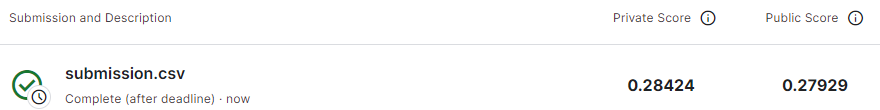

In [10]:
from IPython.display import Image
Image("images/gini_1.PNG")